In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


In [4]:
train_path = "./drive/MyDrive/train_dataset3.npz"  # Replace with your dataset path
data_train = np.load(train_path)

In [5]:
# Load data
X = data_train['X']
y = data_train['y']
class_names = data_train['class_names']

# Display dataset information
print("Loaded dataset:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Class names: {class_names}")
print(f"Example labels: {y[:5]}")

Loaded dataset:
X shape: (66000, 64, 64, 3)
y shape: (66000,)
Class names: ['Abuse' 'Arrest' 'Arson' 'Assault' 'Burglary' 'Explosion' 'Fighting'
 'Normalvideos' 'RoadAccidents' 'Robbery' 'Shooting' 'Shoplifting'
 'Stealing' 'Vandalism']
Example labels: [0 0 0 0 0]


In [6]:
# Step 3: Preprocess Data

# Normalize pixel values
X = X.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]

# One-hot encode labels
# Assuming y contains the actual labels (e.g., class indices), not one-hot encoded
y_one_hot = pd.get_dummies(y).values  # One-hot encode based on the labels `y`

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Display data shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (52800, 64, 64, 3), y_train shape: (52800, 13)
X_test shape: (13200, 64, 64, 3), y_test shape: (13200, 13)


In [7]:
#Step 4: Data Augmentation Setup

# Define ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [9]:
# Step 5: Build the Model

# Load ResNet50 without the top layer (to use as a feature extractor)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Add a new classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(y_train.shape[1], activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model (optional)
for layer in base_model.layers:
    layer.trainable = False


In [10]:
# Step 6: Compile the Model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:

# Step 7: Compute Class Weights

# Convert y_train from one-hot encoding to integer labels
y_train_labels = np.argmax(y_train, axis=1)

# Compute class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

# Map class weights to a dictionary
class_weight_dict = dict(zip(np.unique(y_train_labels), class_weights))


In [12]:
# Step 8: Define Callbacks

# Custom callback for progress display
class TrainingProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        print(f" - Loss: {logs['loss']:.4f} - Accuracy: {logs['accuracy']:.4f} "
              f"- Validation Loss: {logs['val_loss']:.4f} - Validation Accuracy: {logs['val_accuracy']:.4f}")

# Checkpoint callback to save the best model during training
checkpoint_callback = ModelCheckpoint(
    'best_model.keras',  # Change file extension to .keras
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)



In [1]:
# Step 9: Train the Model

epochs = 200
batch_size = 256

# Train the model with data augmentation
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    epochs=epochs,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_callback],
    verbose=1  # Suppress the default progress bar
)

NameError: name 'model' is not defined

In [13]:
from tensorflow.keras.models import load_model

# Load the model saved in the checkpoint
model = load_model('best_model.keras')

# Verify that the model was loaded correctly
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 70, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 32, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 32, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 32, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 34, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 16, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 16, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 16, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 16, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 16, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 29,922,217 (114.14 MB)

 Trainable params: 2,111,501 (8.05 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 4,223,004 (16.11 MB)

NameError: name 'history' is not defined

In [17]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=1024),
    validation_data=(X_test, y_test),
    epochs=50,  # You can change this to a smaller number if you've already trained for some epochs
    class_weight=class_weight_dict,
    callbacks=[checkpoint_callback],  # Keep the checkpoint callback to save again if needed
    verbose=1
)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6884 - loss: 0.8368
Epoch 1: val_loss improved from inf to 0.65966, saving model to best_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.6885 - loss: 0.8367 - val_accuracy: 0.7850 - val_loss: 0.6597
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6940 - loss: 0.8118
Epoch 2: val_loss did not improve from 0.65966
52/52 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.6941 - loss: 0.8117 - val_accuracy: 0.7706 - val_loss: 0.6795
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6967 - loss: 0.8044
Epoch 3: val_loss did not improve from 0.65966
52/52 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.6968 - loss: 0.8044 - val_accuracy: 0.7628 - val_loss: 0.7109
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7008 - loss: 0.7965
Epoch 4: val_loss did not improve from 0.65966
52/52 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7007 - loss: 0.7968 - val_accuracy: 0.7578 - va

In [25]:
missing_classes = set(range(len(class_names))) - set(y)
print(f"Missing classes: {missing_classes}")


Missing classes: {10}


In [26]:
from collections import Counter

label_counts = Counter(y)
print("Label counts in the dataset:")
print(label_counts)


Label counts in the dataset:
Counter({7: 30000, 0: 3000, 1: 3000, 2: 3000, 3: 3000, 4: 3000, 5: 3000, 6: 3000, 8: 3000, 9: 3000, 11: 3000, 12: 3000, 13: 3000})


In [19]:
# Step 10: Save the Model

# Save the trained model in HDF5 format
model_h5_path = "./drive/MyDrive/my_resnetkeras_model.keras"
model.save(model_h5_path)  # Save the model
print(f"\nModel saved in HDF5 format at: {model_h5_path}")



Model saved in HDF5 format at: ./drive/MyDrive/my_resnetkeras_model.keras


In [20]:
# Step 11: Evaluate the Model

# Evaluate the model on the test set
scores = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Accuracy: {scores[1] * 100:.2f}%")


413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7985 - loss: 0.6017

Test Accuracy: 80.30%


In [21]:
# Step 12: Make Predictions

# Get predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


413/413 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step


In [28]:
print(unique.(y))

SyntaxError: invalid syntax (<ipython-input-28-b0b1f2f75e75>, line 1)

In [23]:
# Step 13: Classification Report

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))



Classification Report:


ValueError: Number of classes, 13, does not match size of target_names, 14. Try specifying the labels parameter

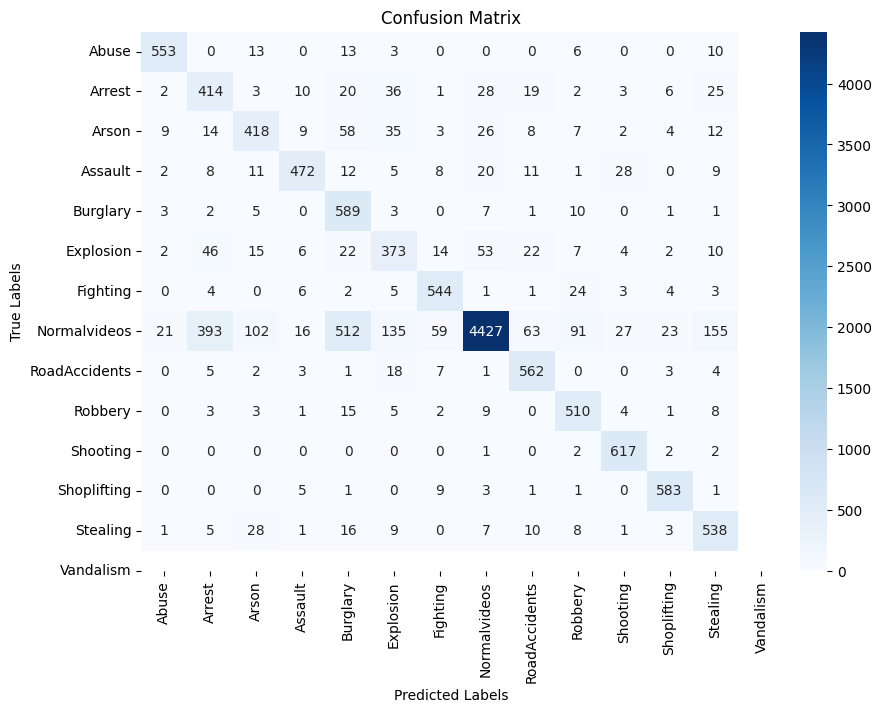

In [29]:
# Step 14: Confusion Matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()